In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import random
from torchvision import transforms
import os 

from PIL import Image

import os , itertools
print(os.listdir("../dataset/horse2zebra"))

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

['testA', 'trainB', 'testB', 'trainA']


In [6]:
params = {
    'batch_size':1,
    'input_size':256,
    'resize_scale':286,
    'crop_size':256,
    'fliplr':True,
    #model params
    'num_epochs':100,
    'decay_epoch':100,
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.0002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}

data_dir = '../dataset/horse2zebra'

In [7]:
def to_np(x):
    return x.data.cpu().numpy()
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False,  show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [8]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [9]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)

        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)

In [10]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [11]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [12]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out

In [13]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)


In [15]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_data_A = DatasetFromFolder(data_dir, subfolder='trainA', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=params['batch_size'], shuffle=True)
train_data_B = DatasetFromFolder(data_dir, subfolder='trainB', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=params['batch_size'], shuffle=True)
#Load test data
test_data_A = DatasetFromFolder(data_dir, subfolder='testA', transform=transform)
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=params['batch_size'], shuffle=False)
test_data_B = DatasetFromFolder(data_dir, subfolder='testB', transform=transform)
test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=params['batch_size'], shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [16]:
# Get specific test images
test_real_A_data = train_data_A.__getitem__(11).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = train_data_B.__getitem__(91).unsqueeze(0)
#print(test_real_A_data)
#Build Model 
G_A = Generator(3, params['ngf'], 3, params['num_resnet']).cuda() # input_dim, num_filter, output_dim, num_resnet
G_B = Generator(3, params['ngf'], 3, params['num_resnet']).cuda()

D_A = Discriminator(3, params['ndf'], 1).cuda() # input_dim, num_filter, output_dim
D_B = Discriminator(3, params['ndf'], 1).cuda()

G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)


G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

# # Training GAN
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

# Generated image pool
num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)

Epoch [96/100], Step [1/1067], D_A_loss: 0.0559, D_B_loss: 0.0198, G_A_loss: 0.6700, G_B_loss: 0.5125
Time elapsed: 218.55 min
Epoch [96/100], Step [101/1067], D_A_loss: 0.0492, D_B_loss: 0.0271, G_A_loss: 0.5586, G_B_loss: 0.8495
Time elapsed: 218.76 min
Epoch [96/100], Step [201/1067], D_A_loss: 0.0930, D_B_loss: 0.0101, G_A_loss: 0.9219, G_B_loss: 0.4740
Time elapsed: 218.97 min
Epoch [96/100], Step [301/1067], D_A_loss: 0.0885, D_B_loss: 0.0189, G_A_loss: 0.5708, G_B_loss: 0.4385
Time elapsed: 219.19 min
Epoch [96/100], Step [401/1067], D_A_loss: 0.1127, D_B_loss: 0.0265, G_A_loss: 0.7329, G_B_loss: 0.4160
Time elapsed: 219.40 min
Epoch [96/100], Step [501/1067], D_A_loss: 0.0688, D_B_loss: 0.0404, G_A_loss: 0.7602, G_B_loss: 0.5642
Time elapsed: 219.62 min
Epoch [96/100], Step [601/1067], D_A_loss: 0.0548, D_B_loss: 0.1183, G_A_loss: 0.9025, G_B_loss: 0.7505
Time elapsed: 219.83 min
Epoch [96/100], Step [701/1067], D_A_loss: 0.1230, D_B_loss: 0.0736, G_A_loss: 0.9319, G_B_loss: 0.

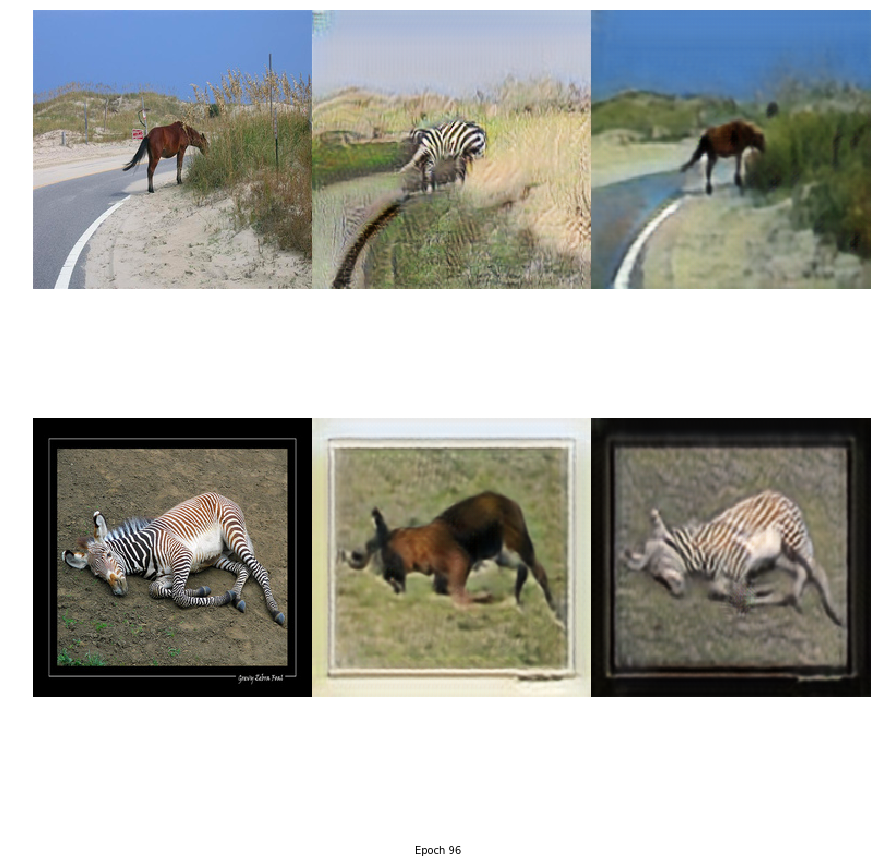

Epoch [97/100], Step [1/1067], D_A_loss: 0.0820, D_B_loss: 0.0668, G_A_loss: 0.4273, G_B_loss: 0.4488
Time elapsed: 220.84 min
Epoch [97/100], Step [101/1067], D_A_loss: 0.0798, D_B_loss: 0.0252, G_A_loss: 0.9714, G_B_loss: 0.5310
Time elapsed: 221.06 min
Epoch [97/100], Step [201/1067], D_A_loss: 0.0504, D_B_loss: 0.0484, G_A_loss: 0.8236, G_B_loss: 0.3634
Time elapsed: 221.27 min
Epoch [97/100], Step [301/1067], D_A_loss: 0.1231, D_B_loss: 0.0218, G_A_loss: 1.0424, G_B_loss: 0.5773
Time elapsed: 221.49 min
Epoch [97/100], Step [401/1067], D_A_loss: 0.1056, D_B_loss: 0.0138, G_A_loss: 1.0884, G_B_loss: 0.9132
Time elapsed: 221.70 min
Epoch [97/100], Step [501/1067], D_A_loss: 0.0378, D_B_loss: 0.0305, G_A_loss: 0.5219, G_B_loss: 0.3704
Time elapsed: 221.92 min
Epoch [97/100], Step [601/1067], D_A_loss: 0.0435, D_B_loss: 0.0448, G_A_loss: 0.9120, G_B_loss: 0.7441
Time elapsed: 222.13 min
Epoch [97/100], Step [701/1067], D_A_loss: 0.2296, D_B_loss: 0.0528, G_A_loss: 1.0017, G_B_loss: 0.

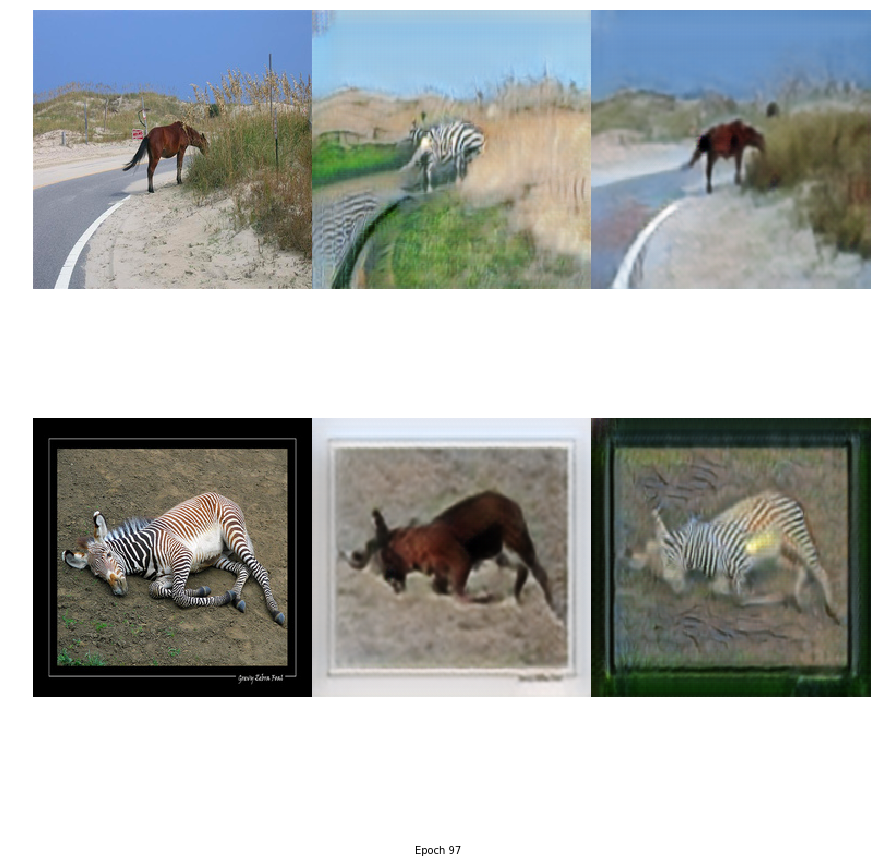

Epoch [98/100], Step [1/1067], D_A_loss: 0.0586, D_B_loss: 0.0477, G_A_loss: 0.6841, G_B_loss: 0.1037
Time elapsed: 223.15 min
Epoch [98/100], Step [101/1067], D_A_loss: 0.0266, D_B_loss: 0.0161, G_A_loss: 0.7248, G_B_loss: 0.8091
Time elapsed: 223.36 min
Epoch [98/100], Step [201/1067], D_A_loss: 0.0627, D_B_loss: 0.0535, G_A_loss: 0.5063, G_B_loss: 0.7639
Time elapsed: 223.57 min
Epoch [98/100], Step [301/1067], D_A_loss: 0.0710, D_B_loss: 0.0237, G_A_loss: 0.4420, G_B_loss: 0.2770
Time elapsed: 223.79 min
Epoch [98/100], Step [401/1067], D_A_loss: 0.1501, D_B_loss: 0.0308, G_A_loss: 0.7754, G_B_loss: 0.3673
Time elapsed: 224.00 min
Epoch [98/100], Step [501/1067], D_A_loss: 0.0879, D_B_loss: 0.0115, G_A_loss: 0.6386, G_B_loss: 0.6138
Time elapsed: 224.21 min
Epoch [98/100], Step [601/1067], D_A_loss: 0.0551, D_B_loss: 0.0930, G_A_loss: 0.6126, G_B_loss: 0.7757
Time elapsed: 224.43 min
Epoch [98/100], Step [701/1067], D_A_loss: 0.1449, D_B_loss: 0.1299, G_A_loss: 0.9494, G_B_loss: 0.

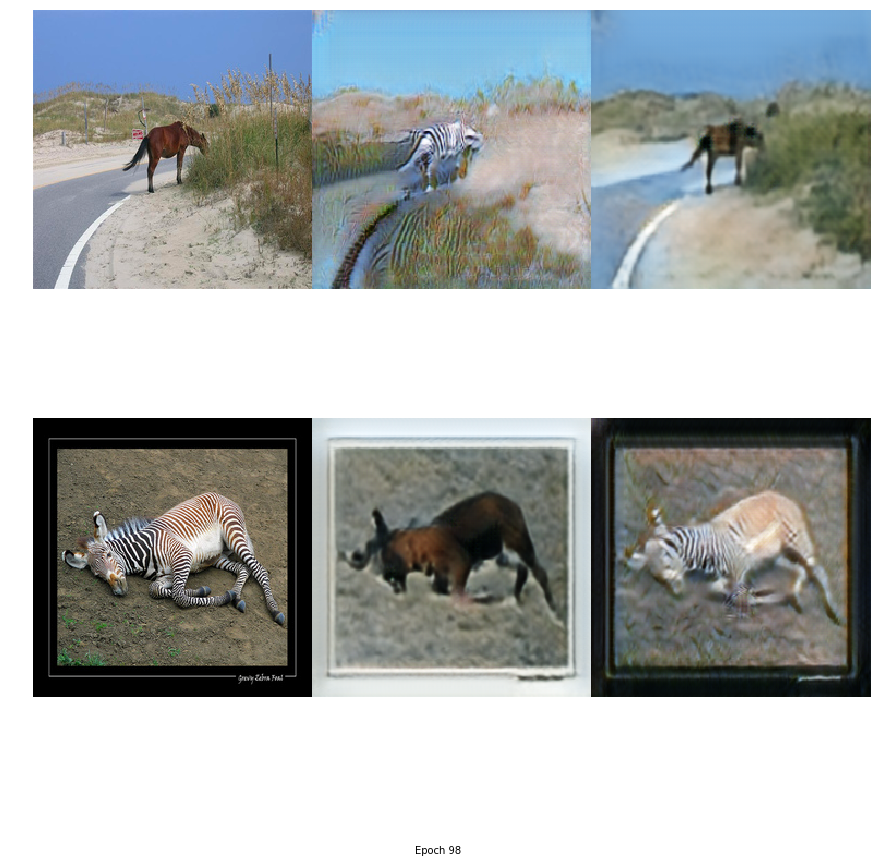

Epoch [99/100], Step [1/1067], D_A_loss: 0.0389, D_B_loss: 0.0280, G_A_loss: 0.9580, G_B_loss: 0.7637
Time elapsed: 225.45 min
Epoch [99/100], Step [101/1067], D_A_loss: 0.0363, D_B_loss: 0.0372, G_A_loss: 0.6715, G_B_loss: 0.7147
Time elapsed: 225.66 min
Epoch [99/100], Step [201/1067], D_A_loss: 0.0688, D_B_loss: 0.0456, G_A_loss: 0.8749, G_B_loss: 0.5082
Time elapsed: 225.88 min
Epoch [99/100], Step [301/1067], D_A_loss: 0.0224, D_B_loss: 0.0399, G_A_loss: 0.3080, G_B_loss: 0.4329
Time elapsed: 226.09 min
Epoch [99/100], Step [401/1067], D_A_loss: 0.0931, D_B_loss: 0.0235, G_A_loss: 0.6905, G_B_loss: 0.8839
Time elapsed: 226.30 min
Epoch [99/100], Step [501/1067], D_A_loss: 0.2334, D_B_loss: 0.1460, G_A_loss: 0.5863, G_B_loss: 0.6338
Time elapsed: 226.51 min
Epoch [99/100], Step [601/1067], D_A_loss: 0.1035, D_B_loss: 0.0204, G_A_loss: 0.9255, G_B_loss: 1.2928
Time elapsed: 226.73 min
Epoch [99/100], Step [701/1067], D_A_loss: 0.0375, D_B_loss: 0.0176, G_A_loss: 0.6918, G_B_loss: 0.

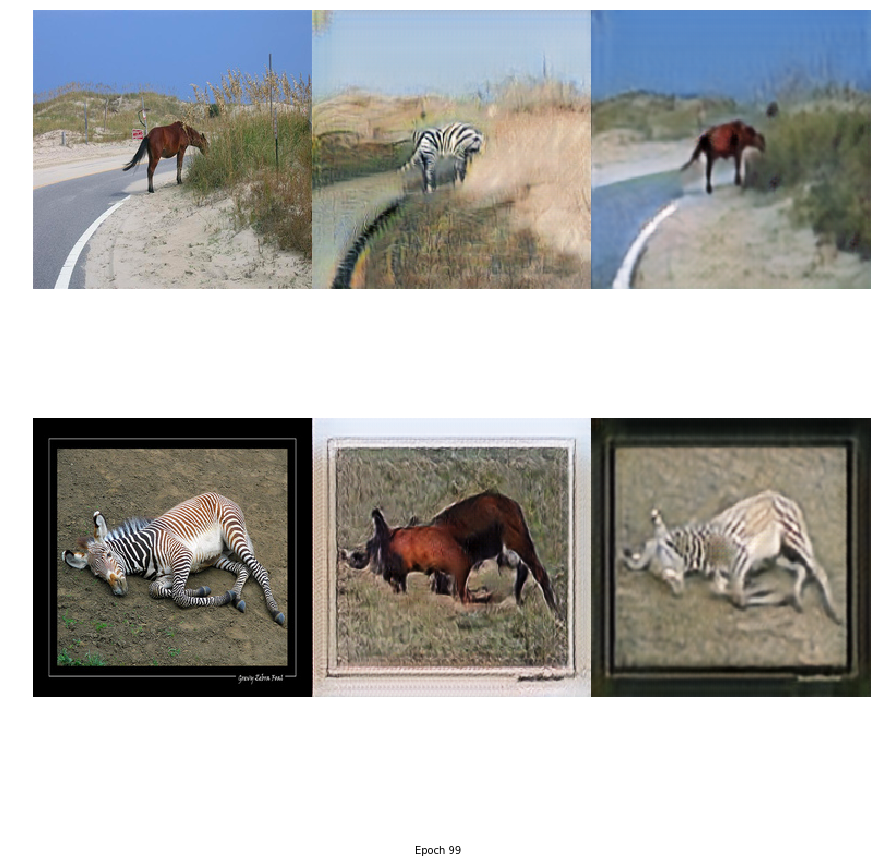

Epoch [100/100], Step [1/1067], D_A_loss: 0.1056, D_B_loss: 0.0343, G_A_loss: 0.7312, G_B_loss: 0.4521
Time elapsed: 227.74 min
Epoch [100/100], Step [101/1067], D_A_loss: 0.0522, D_B_loss: 0.0320, G_A_loss: 0.8939, G_B_loss: 0.5815
Time elapsed: 227.95 min
Epoch [100/100], Step [201/1067], D_A_loss: 0.0839, D_B_loss: 0.0285, G_A_loss: 0.9927, G_B_loss: 0.4353
Time elapsed: 228.17 min
Epoch [100/100], Step [301/1067], D_A_loss: 0.1025, D_B_loss: 0.0152, G_A_loss: 0.5018, G_B_loss: 0.4051
Time elapsed: 228.38 min
Epoch [100/100], Step [401/1067], D_A_loss: 0.1369, D_B_loss: 0.0716, G_A_loss: 0.8125, G_B_loss: 0.4561
Time elapsed: 228.61 min
Epoch [100/100], Step [501/1067], D_A_loss: 0.1170, D_B_loss: 0.0146, G_A_loss: 1.0069, G_B_loss: 0.4469
Time elapsed: 228.82 min
Epoch [100/100], Step [601/1067], D_A_loss: 0.1795, D_B_loss: 0.0249, G_A_loss: 0.3561, G_B_loss: 0.8272
Time elapsed: 229.04 min
Epoch [100/100], Step [701/1067], D_A_loss: 0.0843, D_B_loss: 0.0383, G_A_loss: 0.5284, G_B_

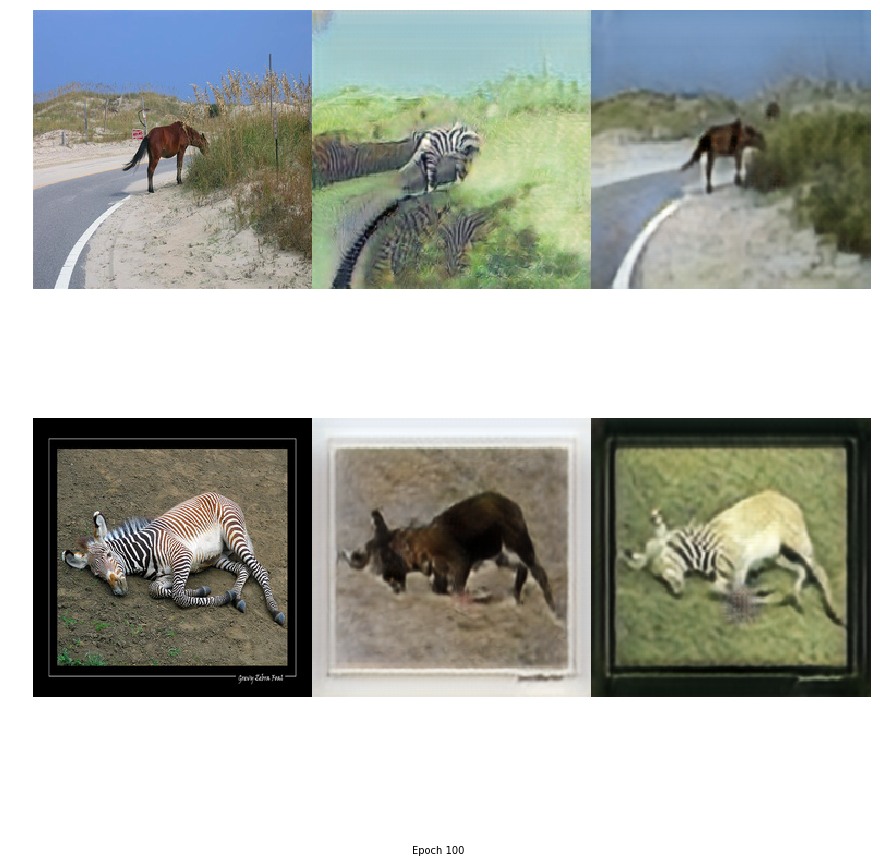

In [39]:
import time
from IPython.display import clear_output

step = 0
start_time = time.time()
for epoch in range(params['num_epochs']):
    if epoch % 5 == 0 : 
        clear_output(wait=True)
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
    # Learing rate decay 
    if(epoch + 1) > params['decay_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= params['lrG'] / (params['num_epochs'] - params['decay_epoch'])
        
    
    # training 
    for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):
        
        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * params['lambdaA']
        
        # B --> A
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))
        
        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * params['lambdaB']
        
        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        
        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))
        
        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))
        
        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, params['num_epochs'], i+1, len(train_data_loader_A), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        step += 1
        
    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    G_A_avg_losses.append(G_A_avg_loss.item())
    G_B_avg_losses.append(G_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
    # Show result for test image
    test_real_A = test_real_A_data.cuda()
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.cuda()
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                         epoch, save=False)
    
    
    

### For 100 epochs

In [ ]:
Epoch [100/100], Step [1/1067], D_A_loss: 0.0951, D_B_loss: 0.0353, G_A_loss: 0.8349, G_B_loss: 0.7306
Time elapsed: 228.28 min
Epoch [100/100], Step [101/1067], D_A_loss: 0.0641, D_B_loss: 0.0257, G_A_loss: 0.7971, G_B_loss: 1.0494
Time elapsed: 228.49 min
Epoch [100/100], Step [201/1067], D_A_loss: 0.0378, D_B_loss: 0.0965, G_A_loss: 0.7978, G_B_loss: 0.2556
Time elapsed: 228.71 min
Epoch [100/100], Step [301/1067], D_A_loss: 0.1687, D_B_loss: 0.0829, G_A_loss: 0.4510, G_B_loss: 0.4292
Time elapsed: 228.92 min
Epoch [100/100], Step [401/1067], D_A_loss: 0.1195, D_B_loss: 0.0328, G_A_loss: 0.7491, G_B_loss: 0.5495
Time elapsed: 229.13 min
Epoch [100/100], Step [501/1067], D_A_loss: 0.0856, D_B_loss: 0.0233, G_A_loss: 1.1268, G_B_loss: 0.5673
Time elapsed: 229.35 min
Epoch [100/100], Step [601/1067], D_A_loss: 0.0638, D_B_loss: 0.0687, G_A_loss: 1.2756, G_B_loss: 0.3686
Time elapsed: 229.56 min
Epoch [100/100], Step [701/1067], D_A_loss: 0.0825, D_B_loss: 0.0295, G_A_loss: 0.5538, G_B_loss: 0.6705
Time elapsed: 229.78 min
Epoch [100/100], Step [801/1067], D_A_loss: 0.3102, D_B_loss: 0.0176, G_A_loss: 0.6596, G_B_loss: 0.8956
Time elapsed: 229.99 min
Epoch [100/100], Step [901/1067], D_A_loss: 0.2186, D_B_loss: 0.0306, G_A_loss: 0.8261, G_B_loss: 0.2876
Time elapsed: 230.21 min
Epoch [100/100], Step [1001/1067], D_A_loss: 0.0429, D_B_loss: 0.0176, G_A_loss: 0.9713, G_B_loss: 0.7730
Time elapsed: 230.43 min

In [ ]:
Epoch [51/100], Step [1/1067], D_A_loss: 0.1816, D_B_loss: 0.1459, G_A_loss: 0.5453, G_B_loss: 1.1908
Time elapsed: 115.04 min
Epoch [51/100], Step [101/1067], D_A_loss: 0.0877, D_B_loss: 0.0326, G_A_loss: 0.8968, G_B_loss: 0.2599
Time elapsed: 115.26 min
Epoch [51/100], Step [201/1067], D_A_loss: 0.0611, D_B_loss: 0.0660, G_A_loss: 0.4791, G_B_loss: 0.6596
Time elapsed: 115.47 min
Epoch [51/100], Step [301/1067], D_A_loss: 0.0970, D_B_loss: 0.0162, G_A_loss: 0.9372, G_B_loss: 0.7595
Time elapsed: 115.68 min
Epoch [51/100], Step [401/1067], D_A_loss: 0.0761, D_B_loss: 0.0851, G_A_loss: 0.4267, G_B_loss: 0.3911
Time elapsed: 115.90 min
Epoch [51/100], Step [501/1067], D_A_loss: 0.0377, D_B_loss: 0.0277, G_A_loss: 0.7050, G_B_loss: 0.2815
Time elapsed: 116.11 min
Epoch [51/100], Step [601/1067], D_A_loss: 0.0288, D_B_loss: 0.0242, G_A_loss: 0.9034, G_B_loss: 0.8601
Time elapsed: 116.32 min
Epoch [51/100], Step [701/1067], D_A_loss: 0.0605, D_B_loss: 0.0876, G_A_loss: 0.4373, G_B_loss: 0.2166
Time elapsed: 116.53 min
Epoch [51/100], Step [801/1067], D_A_loss: 0.1526, D_B_loss: 0.0462, G_A_loss: 0.3839, G_B_loss: 0.2878
Time elapsed: 116.75 min
Epoch [51/100], Step [901/1067], D_A_loss: 0.0636, D_B_loss: 0.0172, G_A_loss: 0.8296, G_B_loss: 0.2420
Time elapsed: 116.96 min
Epoch [51/100], Step [1001/1067], D_A_loss: 0.0517, D_B_loss: 0.0300, G_A_loss: 0.7569, G_B_loss: 0.7934
Time elapsed: 117.18 min

In [ ]:
Epoch [100/100], Step [1/1067], D_A_loss: 0.1056, D_B_loss: 0.0343, G_A_loss: 0.7312, G_B_loss: 0.4521
Time elapsed: 227.74 min
Epoch [100/100], Step [101/1067], D_A_loss: 0.0522, D_B_loss: 0.0320, G_A_loss: 0.8939, G_B_loss: 0.5815
Time elapsed: 227.95 min
Epoch [100/100], Step [201/1067], D_A_loss: 0.0839, D_B_loss: 0.0285, G_A_loss: 0.9927, G_B_loss: 0.4353
Time elapsed: 228.17 min
Epoch [100/100], Step [301/1067], D_A_loss: 0.1025, D_B_loss: 0.0152, G_A_loss: 0.5018, G_B_loss: 0.4051
Time elapsed: 228.38 min
Epoch [100/100], Step [401/1067], D_A_loss: 0.1369, D_B_loss: 0.0716, G_A_loss: 0.8125, G_B_loss: 0.4561
Time elapsed: 228.61 min
Epoch [100/100], Step [501/1067], D_A_loss: 0.1170, D_B_loss: 0.0146, G_A_loss: 1.0069, G_B_loss: 0.4469
Time elapsed: 228.82 min
Epoch [100/100], Step [601/1067], D_A_loss: 0.1795, D_B_loss: 0.0249, G_A_loss: 0.3561, G_B_loss: 0.8272
Time elapsed: 229.04 min
Epoch [100/100], Step [701/1067], D_A_loss: 0.0843, D_B_loss: 0.0383, G_A_loss: 0.5284, G_B_loss: 0.7051
Time elapsed: 229.25 min
Epoch [100/100], Step [801/1067], D_A_loss: 0.0434, D_B_loss: 0.1020, G_A_loss: 1.1025, G_B_loss: 0.4157
Time elapsed: 229.47 min
Epoch [100/100], Step [901/1067], D_A_loss: 0.0251, D_B_loss: 0.0125, G_A_loss: 0.9260, G_B_loss: 0.3701
Time elapsed: 229.68 min
Epoch [100/100], Step [1001/1067], D_A_loss: 0.2104, D_B_loss: 0.0116, G_A_loss: 0.2873, G_B_loss: 1.0652
Time elapsed: 229.89 min

In [49]:
torch.save({
            'G_A': G_A.state_dict(),
            'G_B': G_B.state_dict(),
            'D_A': D_A.state_dict(),
            'D_B': D_B.state_dict(),
            'G_optimizer' : G_optimizer.state_dict(),
            'D_A_optimizer': D_A_optimizer.state_dict(),
            'D_B_optimizer': D_B_optimizer.state_dict(),
            'D_A_losses': D_A_losses,
            'D_B_losses': D_B_losses,
            'G_A_losses': G_A_losses,
            'G_B_losses': G_B_losses, 
            'cycle_A_losses': cycle_A_losses,
            'cycle_B_loesse': cycle_B_losses,
            }, '../checkpoints/torch/cycleGAN.pth')

### Test

In [17]:
checkpoint = torch.load('../checkpoints/torch/cycleGAN.pth')

In [18]:
G_A.load_state_dict(checkpoint['G_A'])
G_B.load_state_dict(checkpoint['G_B'])
D_A.load_state_dict(checkpoint['D_A'])
D_B.load_state_dict(checkpoint['D_B'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

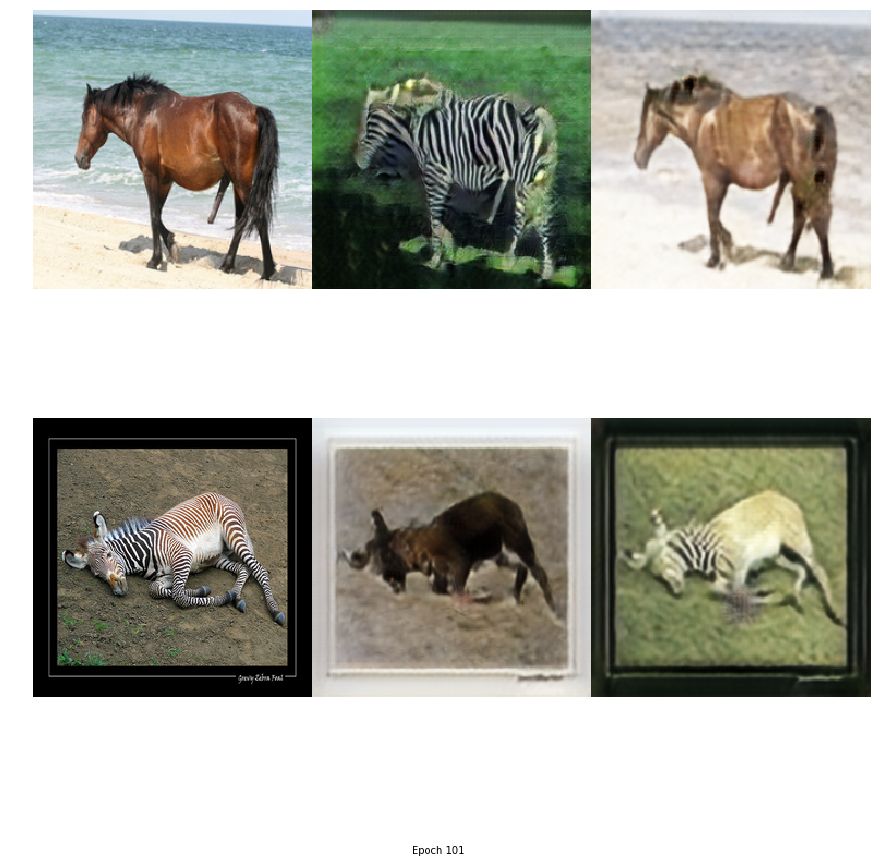

In [28]:
# Get specific test images
test_real_A_data = train_data_A.__getitem__(41).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = test_data_B.__getitem__(5).unsqueeze(0)
test_real_A = test_real_A_data.cuda()
test_fake_B = G_A(test_real_A)
test_recon_A = G_B(test_fake_B)

test_real_B = test_real_B_data.cuda()
test_fake_A = G_B(test_real_B)
test_recon_B = G_A(test_fake_A)

plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                         100, save=False)
